# QUESTION 2

COSE DA FARE:
- GENERALI
    - vedere la notation regarding 12,13,14 e capire se fare le transaction amount > di 500, 1000, 5000 o di abbassarre i range
    
    
- PULIZIA DATASET/ANALISI PRELIMINARE
    - de

## Import dataset and data cleaning

In [228]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib.pyplot import figure
from scipy.spatial.distance import cdist
from random import randint
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from collections import defaultdict
from operator import itemgetter
from yellowbrick.cluster import SilhouetteVisualizer

In [83]:
df=pd.read_csv(r"C:\Users\gianl\Documents\Università_4°anno(2022-2023\ADM\HOMEWORK\HOMEWORK 4\bank_transactions.csv", sep=",")

In [84]:
#traformiamo le variaibli in datetime
df['TransactionTime'] = df['TransactionTime'].apply(lambda x: datetime.strptime(str(x).zfill(6), '%H%M%S'))
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], format = '%d/%m/%y', errors = 'coerce')
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format = '%d/%m/%y', errors = 'coerce')

In [85]:
def times_to_time_deltas(times):
    return list(map(lambda time: pd.Timedelta(hours=time.hour, minutes=time.minute, seconds=time.second), times))
    
df['TransactionDateTime'] = df.TransactionDate + pd.Series(times_to_time_deltas(df.TransactionTime), index=df.TransactionDate.index)
del df['TransactionDate']
del df['TransactionTime']

In [298]:
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionAmount (INR),TransactionDateTime,TransactionAmountUSD
0,T1,C5841053,1994-01-10,F,JAMSHEDPUR,17819.05,25.00,2016-08-02 14:32:07,0.30
1,T2,C2142763,1957-04-04,M,JHAJJAR,2270.69,27999.00,2016-08-02 14:18:58,335.99
2,T3,C4417068,1996-11-26,F,MUMBAI,17874.44,459.00,2016-08-02 14:27:12,5.51
3,T4,C5342380,1973-09-14,F,MUMBAI,866503.21,2060.00,2016-08-02 14:27:14,24.72
4,T5,C9031234,1988-03-24,F,NAVI MUMBAI,6714.43,1762.50,2016-08-02 18:11:56,21.15


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048567 entries, 0 to 1048566
Data columns (total 9 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   TransactionID            1048567 non-null  object        
 1   CustomerID               1048567 non-null  object        
 2   CustomerDOB              987831 non-null   datetime64[ns]
 3   CustGender               1047467 non-null  object        
 4   CustLocation             1048416 non-null  object        
 5   CustAccountBalance       1046198 non-null  float64       
 6   TransactionDate          1048567 non-null  datetime64[ns]
 7   TransactionTime          1048567 non-null  datetime64[ns]
 8   TransactionAmount (INR)  1048567 non-null  float64       
dtypes: datetime64[ns](3), float64(2), object(4)
memory usage: 72.0+ MB


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CustAccountBalance,1046198.0,115403.540056,846485.380601,0.0,4721.76,16792.18,57657.36,1.150355e+08
TransactionAmount (INR),1048567.0,1574.335003,6574.742978,0.0,161.00,459.03,1200.00,1.560035e+06


**There are some missing values but very few compering to the rest of the dataset, so we can drop it**

In [282]:
df.isna().sum()

TransactionID                 0
CustomerID                    0
CustomerDOB                3397
CustGender                 1100
CustLocation                151
CustAccountBalance         2369
TransactionDate               0
TransactionTime               0
TransactionAmount (INR)       0
dtype: int64

In [86]:
df = df.dropna()

**As we can see, there are a lot of birthdates on January 1st, which seems a little strange. There's also some customers birth on 1/1/1800. This is probably some default the bank has where this information is unknown, althought that is a little strange. Since observations that have CustomerDOB equal to 1/1/1800 are an irrelevant part of the whole dataset, we decided to remove them.**

In [283]:
df['CustomerDOB'].value_counts()

1/1/1800    57339
1/1/89        809
1/1/90        784
6/8/91        699
1/1/91        666
            ...  
3/9/60          1
17/11/52        1
11/9/63         1
28/2/47         1
24/10/44        1
Name: CustomerDOB, Length: 17254, dtype: int64

In [288]:
df = df.loc[~(df['CustomerDOB'] == '1/1/1800')]

**There are people born after 2021, so just subtract 100 from the year of birth of these people**

In [87]:
df.loc[df['CustomerDOB'].dt.year >= 2021, ['CustomerDOB']] -= pd.DateOffset(years = 100)

**Let's have a look how many male and female we have in our dataset**

In [41]:
df['CustGender'].value_counts()

M    712454
F    272868
Name: CustGender, dtype: int64

Let's plot it with a pie plot

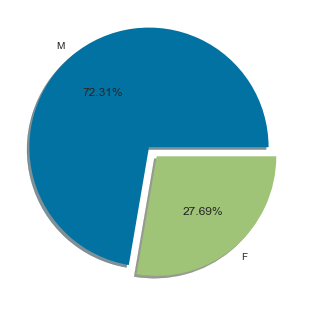

In [88]:
labels = df.CustGender.value_counts().keys()
values = df.CustGender.value_counts().values
explode = (0.1,0)

plt.pie(values,labels=labels,explode=explode,shadow=True,autopct='%1.2f%%');

Now, we want to see the total amount of transactions for females and males and we also want to see the total balance in the female and male accounts.

array([<AxesSubplot:ylabel='CustAccountBalance'>,
       <AxesSubplot:ylabel='TransactionAmount (INR)'>], dtype=object)

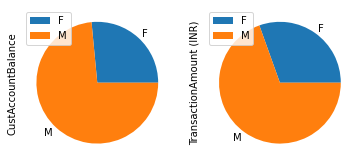

In [54]:
df.groupby(df['CustGender']).sum().plot(kind='pie', subplots=True)

As can be seen from the graphs above, the total amount of transactions of females is not proportional to the total balance of female accounts. In fact, women tend to make higher transactions than men in proportion to their balance.

**Handling the dataset we discovered there are 708 transactions which correspond to an amount of 0**

In [89]:
df[df['TransactionAmount (INR)'] == 0].count()

TransactionID              708
CustomerID                 708
CustomerDOB                708
CustGender                 708
CustLocation               708
CustAccountBalance         708
TransactionAmount (INR)    708
TransactionDateTime        708
dtype: int64

A transaction with an amount of 0 does not make much sense and is perhaps due to some error or some rejected transition that was recorded anyway. For this reason we drop transactions with an amount equal to 0.

In [8]:
df = df.drop(df[df['TransactionAmount (INR)'] == 0].index,axis = 0)

**Let's see the total amount of transactions for each month**

<AxesSubplot:ylabel='TransactionAmount (INR)'>

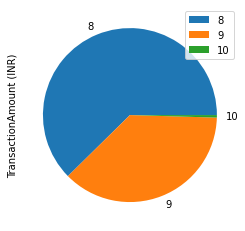

In [56]:
df.groupby(df['TransactionDate'].dt.month).sum().plot(kind='pie', y='TransactionAmount (INR)')

We can therefore see that within the dataset there are only transactions that took place in the months of August, September and October. In particular, most of the transactions were carried out in August.

**Let's now take a look at the ages of the individuals within the dataset.**

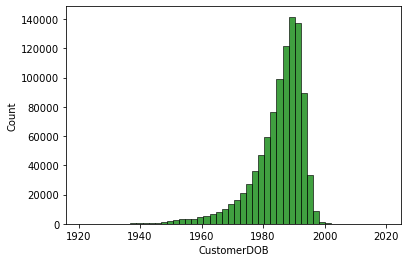

In [70]:
sns.histplot(df.CustomerDOB.dt.year,bins=50, color="green")
plt.show()

It can be seen from the graph that most of the individuals within the dataset in 2016 had an age between 22 to 34 years.

# 2.1 Creating feature engineering

In [90]:
#Let's create a new dataframe called new_df. Here we'll create all the features we have to create.
new_df = pd.DataFrame()

**Number of transactions**

In [91]:
new_df['NumTransaction'] = df.groupby(['CustomerID'])['TransactionID'].count()

**Number of transactions > 100 USD**

We are asked to find transactions with an amount greater than 100 USD. Since, the 'TransactionAmount' feature we have is in INR (it would be the Iranian currency), we first create a variable that corresponds to TransactionAmount, but it is in USD, and then we count how many transactions are greater than 100 USD. To convert INR in USD we must consider that 1 INR is equal to 0.012 USD.

In [92]:
df['TransactionAmountUSD'] = df['TransactionAmount (INR)']*0.012
new_df['AmountTrans>100'] = df[df['TransactionAmountUSD']  > 100].groupby(['CustomerID'])['TransactionAmountUSD'].count()
new_df['AmountTrans>100'] = new_df['AmountTrans>100'].fillna(0)
new_df['AmountTrans>100'] = new_df['AmountTrans>100'].astype(int)

**Average amount of transaction**

In [93]:
new_df['AvgAmountTransaction'] = df.groupby(['CustomerID'])['TransactionAmount (INR)'].agg('mean')

**Average balance**

In [94]:
#The first command is to visualize a float number approximated to two decimal places and not an exponential number.
pd.options.display.float_format = '{:.2f}'.format 
new_df['AvgBalance'] = df.groupby(['CustomerID'])['CustAccountBalance'].agg('mean')

**Average difference between the balance and the transaction amount for each customer**

In [95]:
df['provvisoria'] = df['CustAccountBalance'] - df['TransactionAmount (INR)']
new_df['AvgDiffBalTrans'] = df.groupby(['CustomerID'])['provvisoria'].agg('mean')
del df['provvisoria']

**Gender of customers**

In [96]:
#Since within the dataset there is that a CustomerID corresponds to several people (this is probably due to the fact that
#an account can belong to a family and the transactions can be carried out by all the members of the family), we calculate 
#the mode for each CustomerID for the Gender feature, which is the most frequent gender for each CustomerID.
Gender = df.groupby(['CustomerID'])['CustGender'].agg(pd.Series.mode)

#By calculating the fashion it is possible that for a CustomerID it is possible that a female and a male have made the same
#number of transactions. In this case then we simply consider the first value.
for i in Gender.index:
    Gender[i]=Gender[i][0]

#Let's add the new variable to the 'new_df' dataset.
new_df['Gender'] = Gender

**Most frequent location of the customer**

In [97]:
#We calculate the most frequent location by fashion.
frequent_location = df.groupby(['CustomerID'])['CustLocation'].agg(pd.Series.mode)

#Since by doing the mode we can have a situation where the most frequent location is double and in this case a list is
#created that contains both the most frequent locations, so let's do a for loop to replace the list with the first element
#of the list.
l = []
for i in frequent_location.index:
    if type(frequent_location.loc[i])==str:
        l.append(frequent_location[i])
    else:
        l.append(frequent_location[i][0])
        
#Let's add the new variable to the 'new_df' dataset.
new_df["MostFrequentLocation"] = l

## Create 20 additional features

The addictional futures that we will cosider are:

1. Highest transiction amount in USD
2. Lowest transiction amount in USD
3. Highest balance a customer has ever had in USD
4. Lowest balance a customer has ever had in USD
5. Average amount of transactions in USD
6. Average balance in USD
7. Median amount of transactions in USD
7. Number of transaction carried out just during August
8. Number of transaction carried out just during September
9. Number of transaction carried out just during October
10. Age of customers on transition days
11. Number of transactions > 1000 USD
12. Number of transactions > 5000 USD
13. Number of transactions > 10000 USD
14. Number of times a transition has been made in the most frequent location of the customer
15. Number of transitions made in the night (23-06)
16. Number of transitions made in the morning (07-14)
17. Number of transitions made in the evening (15-22)
19. Average time between transactions
20. Season of birthday (Winter, Spring, Summer, Autumn)

**Notation regarding variables 8,9,10**

With regard to variables 5, 6 and 7, at the beginning we thought to see the number of transactions carried out during the 4 different seasons, but later we noticed that the transactions within the dataset were all carried out in the months of August, September and October. For this reason we have decided to create 3 new variables that tell us how many transactions users have made in the different months (August, September and October).

The following cell shows us that the transactions were actually carried out only in the 3 months indicated above.

In [76]:
df.groupby(df['TransactionDate'].dt.month).count()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
TransactionDate,,,,,,,,,
8,613605,613605,613605,613605,613605,613605,613605,613605,613605
9,368307,368307,368307,368307,368307,368307,368307,368307,368307
10,3410,3410,3410,3410,3410,3410,3410,3410,3410


**Notation regarding variables 12,13,14**

In [494]:
#I WOULD LIKE TO MAKE A RANGE BAR PLOT, THAT IS TO COUNT THE NUMBER OF TRANSACTIONS BETWEEN 100 AND 500, THEN THE ONE BETWEEN 500 AND 2000, 
#THE ONE BETWEEN 2000 AND 10000 ETC AND I WOULD LIKE TO SHOW THAT THERE ARE ONLY 47K TRANSACTIONS> OF 5000 SO I DECIDED TO CREATE THE VARIABLES> 500,
#> 1000 and> 5000. THAT MEANS, I TAKEN INTERVALS NOT THAT GREAT BECAUSE OTHERWISE HAD LITTLE SENSE.
#FOR NOW I CAN SHOW WHAT I SAID WITH A COMMAND BUT IT WAS NICE TO MAKE A GRAPH THAT SHOWED IT BUT I DON'T KNOW HOW TO DO IT
df.TransactionID[df['TransactionAmountUSD'] > 20].count()
#df[df['TransactionAmountUSD'] > 1000].count()
#df[df['TransactionAmountUSD'] > 2000].count()
#df[df['TransactionAmountUSD'] > 5000].count()


174328

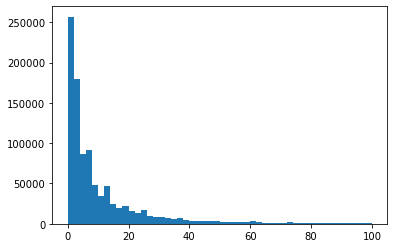

In [789]:
plt.hist(df.TransactionAmountUSD, range=[0,100], bins = 50)
plt.show()

In [450]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 985322 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            985322 non-null  object        
 1   CustomerID               985322 non-null  object        
 2   CustomerDOB              985322 non-null  datetime64[ns]
 3   CustGender               985322 non-null  object        
 4   CustLocation             985322 non-null  object        
 5   CustAccountBalance       985322 non-null  float64       
 6   TransactionAmount (INR)  985322 non-null  float64       
 7   TransactionDateTime      985322 non-null  datetime64[ns]
 8   TransactionAmountUSD     985322 non-null  float64       
 9   CustAccountBalanceUSD    985322 non-null  float64       
dtypes: datetime64[ns](2), float64(4), object(4)
memory usage: 82.7+ MB


#### Once the additional features considered have been defined, we create them and add them to the 'new_df' dataset.

**1** Highest transiction amount in USD

In [98]:
new_df['MaxAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('max')

**2** Lowest transiction amount in USD

In [99]:
new_df['MinAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('min')

**3** Highest balance a customer has ever had in USD

In [100]:
df['CustAccountBalanceUSD'] = df['CustAccountBalance']*0.012
new_df['MaxBalanceUSD'] = df.groupby(['CustomerID'])['CustAccountBalanceUSD'].agg('max')

**4** Lowest balance a customer has ever had in USD

In [101]:
new_df['MinBalanceUSD'] = df.groupby(['CustomerID'])['CustAccountBalanceUSD'].agg('min')

**5** Average amount of transactions in USD

In [102]:
new_df['AvgAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('mean')

**6** Average balance in USD

In [103]:
pd.options.display.float_format = '{:.2f}'.format 
df['CustAccountBalanceUSD'] = df['CustAccountBalance']*0.012
new_df['AvgBalanceUSD'] = df.groupby(['CustomerID'])['CustAccountBalanceUSD'].agg('mean')

**7** Median amount of transactions in USD

In [104]:
new_df['MedianAmountTransactionUSD'] = df.groupby(['CustomerID'])['TransactionAmountUSD'].agg('median')

**8** Number of transaction carried out just during August

In [105]:
in_august = df[df['TransactionDateTime'].dt.month == 8]
new_df['TransactionAugust'] = in_august.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['TransactionAugust'] = new_df['TransactionAugust'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['TransactionAugust'] = new_df['TransactionAugust'].astype(int)

**9** Number of transaction carried out just during September

In [106]:
in_september = df[df['TransactionDateTime'].dt.month == 9]
new_df['TransactionSeptember'] = in_september.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['TransactionSeptember'] = new_df['TransactionSeptember'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['TransactionSeptember'] = new_df['TransactionSeptember'].astype(int)

**10** Number of transaction carried out just during October

In [107]:
in_october = df[df['TransactionDateTime'].dt.month == 10]
new_df['TransactionOctober'] = in_october.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['TransactionOctober'] = new_df['TransactionOctober'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['TransactionOctober'] = new_df['TransactionOctober'].astype(int)

**11** Age of customers on transition days

In [108]:
ex = df.groupby(['CustomerID'])[['TransactionDateTime','CustomerDOB']].first()
new_df['Age'] = ex['TransactionDateTime'].dt.year - ex['CustomerDOB'].dt.year

**12** Number of transactions > 5 USD

In [109]:
new_df['AmountTrans>5USD'] = df[df['TransactionAmountUSD']  > 5].groupby(["CustomerID"])["TransactionAmountUSD"].count()
new_df['AmountTrans>5USD'] = new_df['AmountTrans>5USD'].fillna(0)
new_df['AmountTrans>5USD'] = new_df['AmountTrans>5USD'].astype(int)

**13** Number of transactions > 20 USD

In [110]:
new_df['AmountTrans>20USD'] = df[df['TransactionAmountUSD']  > 20].groupby(["CustomerID"])["TransactionAmountUSD"].count()
new_df['AmountTrans>20USD'] = new_df['AmountTrans>20USD'].fillna(0)
new_df['AmountTrans>20USD'] = new_df['AmountTrans>20USD'].astype(int)

**14** Number of transactions > 50 USD

In [111]:
new_df['AmountTrans>50USD'] = df[df['TransactionAmountUSD']  > 50].groupby(["CustomerID"])["TransactionAmountUSD"].count()
new_df['AmountTrans>50USD'] = new_df['AmountTrans>50USD'].fillna(0)
new_df['AmountTrans>50USD'] = new_df['AmountTrans>50USD'].astype(int)

**15** Number of times a transition has been made in the most frequent location of the customer

In [112]:
new_df['n_transactions_in_most_freq_loc'] = df.groupby(["CustomerID", "CustLocation"])['CustLocation'].count().max(level=0)

C:\Users\gianl\AppData\Local\Temp\ipykernel_3348\2305568774.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  new_df['n_transactions_in_most_freq_loc'] = df.groupby(["CustomerID", "CustLocation"])['CustLocation'].count().max(level=0)


**16** Number of transitions made in the night (23-06)

In [113]:
after_twentythree = df[df['TransactionDateTime'].dt.hour >= 23]
before_six = df[df['TransactionDateTime'].dt.hour <= 6]
between_twentythree_six = pd.concat([after_twentythree,before_six], ignore_index = True)
new_df['Transaction_23-06'] = between_twentythree_six.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['Transaction_23-06'] = new_df['Transaction_23-06'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['Transaction_23-06'] = new_df['Transaction_23-06'].astype(int)

**17** Number of transitions made in the morning (07-14)

In [114]:
after_seven = df[df['TransactionDateTime'].dt.hour >= 7]
between_seven_forteen = after_seven[after_seven['TransactionDateTime'].dt.hour <= 14]
new_df['Transaction_7-14'] = between_seven_forteen.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['Transaction_7-14'] = new_df['Transaction_7-14'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['Transaction_7-14'] = new_df['Transaction_7-14'].astype(int)

**18** Number of transitions made in the evening (15-22)

In [116]:
after_fifteen = df[df['TransactionDateTime'].dt.hour >= 15]
between_fifteen_twentytwo = after_fifteen[after_fifteen['TransactionDateTime'].dt.hour <= 22]
new_df['Transaction_15-22'] = between_fifteen_twentytwo.groupby(['CustomerID'])['TransactionDateTime'].count()
new_df['Transaction_15-22'] = new_df['Transaction_15-22'].fillna(0) #we replace NaN values, that is who didn't make transaction in summer, with 0.
new_df['Transaction_15-22'] = new_df['Transaction_15-22'].astype(int)

**19** Average time between transactions

In [117]:
transaction_time_group = df.groupby(['CustomerID'])['TransactionDateTime']
avg_time_between = (transaction_time_group.max() - transaction_time_group.min()) / (transaction_time_group.count() - 1)

For customers with only a single transaction, we would get a `NaT`, so we need to fill it.

In [118]:
avg_time_between.fillna(pd.Timedelta(0), inplace=True)
avg_seconds_between = list(map(lambda td: td.total_seconds(), avg_time_between))

In [119]:
new_df['avg_seconds_between_transactions'] = avg_seconds_between

**20** Season of birthday (Winter, Spring, Summer, Autumn)

In [120]:
def get_season(month):
    """Gets the name of the meteorological season that corresponds to the provided month.
    
    :args
    month (int) - the number of the month. Should be in the interval [1, 12].
    
    :returns
    the name of the meteorological month of the given month. None if the month is outside the interval [1, 12]
    """
    if month in range(1, 3) or month == 12:
        return 'winter'
    if month in range(3, 6):
        return 'spring'
    if month in range(6, 9):
        return 'summer'
    if month in range(9, 12):
        return 'autumn'

In [121]:
birthday_month = df.groupby(['CustomerID'])['CustomerDOB'].first().dt.month

In [122]:
new_df['DOB_season'] = list(map(get_season, birthday_month))

**This is the complete dataset with all 27 features**

In [123]:
new_df.head()

,NumTransaction,AmountTrans>100,AvgAmountTransaction,AvgBalance,AvgDiffBalTrans,Gender,MostFrequentLocation,MaxAmountTransactionUSD,MinAmountTransactionUSD,MaxBalanceUSD,...,Age,AmountTrans>5USD,AmountTrans>20USD,AmountTrans>50USD,n_transactions_in_most_freq_loc,Transaction_23-06,Transaction_7-14,Transaction_15-22,avg_seconds_between_transactions,DOB_season
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0,2553.00,76340.63,73787.63,F,NEW DELHI,57.00,4.27,1442.17,...,24,1,1,1,1,1,1,0,4188344.00,summer
C1010012,1,0,1499.00,24204.49,22705.49,M,MUMBAI,17.99,17.99,290.45,...,22,1,0,0,1,0,0,1,0.00,summer
C1010014,2,0,727.50,100112.95,99385.45,F,MUMBAI,14.46,3.00,1942.19,...,24,1,0,0,2,0,0,2,541094.00,summer
C1010018,1,0,30.00,496.18,466.18,F,CHAMPARAN,0.36,0.36,5.95,...,26,0,0,0,1,0,0,1,0.00,spring
C1010024,1,0,5000.00,87058.65,82058.65,M,KOLKATA,60.00,60.00,1044.70,...,51,1,1,1,1,0,1,0,0.00,summer


# 2.2 Reduce the dimensionality

Since we have a dataset that contains 27 variables, we want to reduce the number of features to work with. To do this, we tried multiple way to find the best one to reduce dimensionality. Not being able to apply a simple PCA as we are dealing with qualitative and quantitative variables, we tried the following ways:
1. Apply Factor Analysis for Mixed Data: This way of proceeding did not require normalization, however trying to apply it, 10 principal components emerged to explain at least 70% of the variance, however we would like to further reduce the dimensionality, so we thought of a other way.


2. Apply the PCA converting all the qualitative variables to make them quantitative (binary for example): in this way the principal components that explain 70% of the variability are 7, so we tried another way to see if we could reduce the dimensionality even more.


3. Apply the PCA by removing the qualitative variables: given that there are only three qualitative variables, namely 'gender', 'MostFrequentLocation' and 'DOB_season', if we eliminate them we see that the main components that explain at least 70% of the variability are 3/4, so let's go this way!

PCA (Principal Component Analysis) has the advantage of reducing some variables, by removing those that are highly correlated with each other. On the other hand, through PCA some information will be lost and the result will be to have features that are less interpretable.

**Let's go for the third way mantioned above**

So let's create a copy of new_df and then remove the qualitative features that are:
- 'Gender'
- 'MostFrequentLocation'
- 'DOB_season'

In [124]:
new_df2 = new_df.copy()

In [125]:
del new_df2['Gender']
del new_df2['MostFrequentLocation']
del new_df2['DOB_season']

In [126]:
new_df2.head()

,NumTransaction,AmountTrans>100,AvgAmountTransaction,AvgBalance,AvgDiffBalTrans,MaxAmountTransactionUSD,MinAmountTransactionUSD,MaxBalanceUSD,MinBalanceUSD,AvgAmountTransactionUSD,...,TransactionOctober,Age,AmountTrans>5USD,AmountTrans>20USD,AmountTrans>50USD,n_transactions_in_most_freq_loc,Transaction_23-06,Transaction_7-14,Transaction_15-22,avg_seconds_between_transactions
CustomerID,,,,,,,,,,,,,,,,,,,,,
C1010011,2,0,2553.00,76340.63,73787.63,57.00,4.27,1442.17,390.01,30.64,...,0,24,1,1,1,1,1,1,0,4188344.00
C1010012,1,0,1499.00,24204.49,22705.49,17.99,17.99,290.45,290.45,17.99,...,0,22,1,0,0,1,0,0,1,0.00
C1010014,2,0,727.50,100112.95,99385.45,14.46,3.00,1942.19,460.53,8.73,...,0,24,1,0,0,2,0,0,2,541094.00
C1010018,1,0,30.00,496.18,466.18,0.36,0.36,5.95,5.95,0.36,...,0,26,0,0,0,1,0,0,1,0.00
C1010024,1,0,5000.00,87058.65,82058.65,60.00,60.00,1044.70,1044.70,60.00,...,0,51,1,1,1,1,0,1,0,0.00


**To normalize or not to normalize... that is the question.....**

The **choice we make is to normalize** because some units of measurement of the features are different from each other and because the features have a very different variability from each other; normalizing is therefore necessary (we think that in this case it is really mandatory to normalize in order to have PCA results that make sense:

In [167]:
scaler = preprocessing.MinMaxScaler()

In [168]:
new_df_normalized = scaler.fit_transform(new_df2)

In [169]:
new_df_normalized = pd.DataFrame(new_df_normalized, columns = ["NumTransaction","AmountTrans>100","AvgAmountTransaction",
"AvgBalance","AvgDiffBalTrans","MaxAmountTransactionUSD","MinAmountTransactionUSD","MaxBalanceUSD", "MinBalanceUSD",
"AvgAmountTransactionUSD","AvgBalanceUSD","MedianAmountTransactionUSD","TransactionAugust","TransactionSeptember", 
"TransactionOctober", "Age","AmountTrans>5USD", "AmountTrans>20USD", "AmountTrans>50USD","n_transactions_in_most_freq_loc",
"Transaction_23-06", "Transaction_7-14",'Transaction_15-22','avg_seconds_between_transactions'])

In [170]:
def PCAplot(datanorm):
    pca = PCA().fit(datanorm)
    plt.figure(figsize=(10,8))

    # Percentage of variance explained by each principal components
    plt.plot(np.cumsum(pca.explained_variance_ratio_)) 
    plt.hlines(0.7, 0, 24, colors = 'orange')
    #plt.vlines(4, 1, 0, colors = 'green')
    plt.xlabel('Number of principal components')
    plt.ylabel('Explained Variance')

    plt.show()

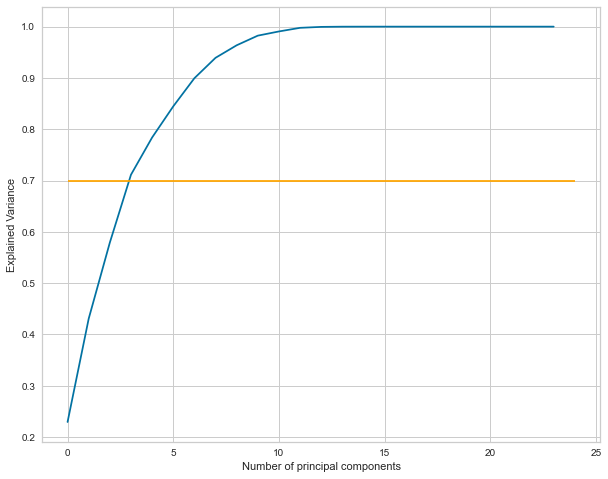

In [171]:
PCAplot(new_df_normalized)

From the graph above it can be seen that the PCA is very efficient, in fact if by absurd we wanted to explain 100% of the variability, from 24 variables we could pass to 11 principal components and not lose any information. However, we are interested in explaining at least 70% of the variance and to do this maybe 4 principal components would suffice (we will see it numerically speaking shortly). However, it can be seen that in the graph, in correspondence with 5 p.c. (actually it is in corrispondence with 4 because the graph on the x axis starts from 0, therefore 4 on the x axis would mean 5 c.p) there seems to be the shape of an elbow and this is a hint from the graph on how many p.c. to take.

### Elbow method

In [174]:
pca = PCA(n_components=10) 
principalcompo = pca.fit_transform(new_df_normalized)

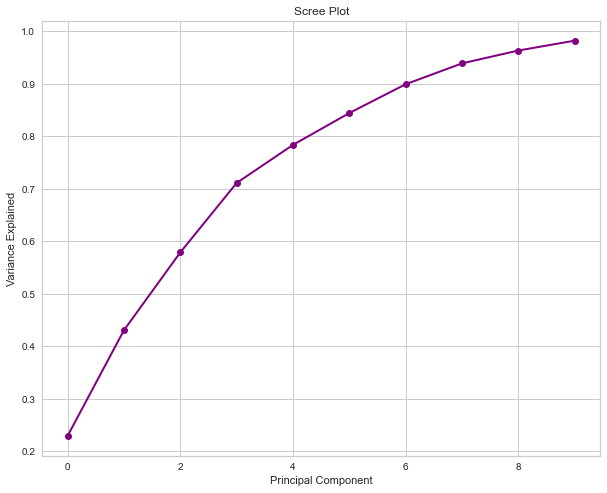

In [175]:
figure(figsize=(10, 8))
PCA_values = np.arange(pca.n_components) 
plt.plot(PCA_values, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=2, color='purple')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

As can be seen again from the graph, at 4 (i.e. 5 p.c.) the graph takes on an elbow shape.

Now let's look at how much variance is explained by the principal components and let's choose the number of p.c. to take into account.

In [179]:
pca = PCA(n_components=4) 
principalcompo = pca.fit_transform(new_df_normalized)
pca_df = pd.DataFrame(data = principalcompo)  

In [180]:
print(pca.explained_variance_ratio_.cumsum())

[0.22938866 0.43075912 0.57909134 0.71134523]


In [181]:
print('The variance explained by 5 principal components is: ', sum(pca.explained_variance_ratio_)*100)

The variance explained by 5 principal components is:  71.13452262066524


**In conclusion, given that 4 principal components explain just under 70% of the variance, and given that in correspondence with 5 principal components there is an elbow shape in the graph, 5 principal components are taken.**

In [182]:
pd.options.display.float_format = '{:.3f}'.format 
pca_df.head(10)

,0,1,2,3
0,0.356,0.374,0.089,-0.101
1,0.021,-0.122,-0.100,-0.010
2,0.249,-0.150,-0.206,-0.210
3,-0.081,-0.163,0.158,-0.029
4,0.102,0.261,-0.085,0.290
5,-0.095,0.177,-0.092,0.007
6,0.105,0.136,-0.200,-0.154
7,0.194,0.176,-0.187,-0.291
8,-0.204,0.139,-0.093,-0.034
9,0.301,0.000,-0.090,0.433


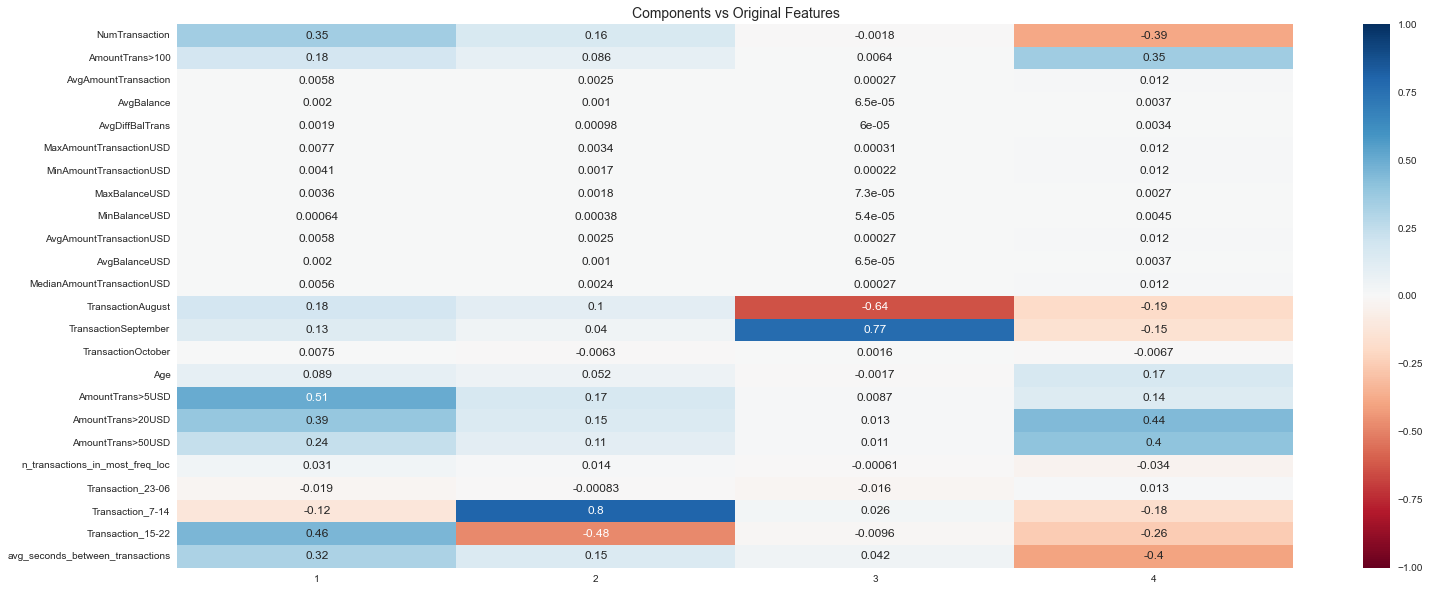

In [187]:
plt.figure(figsize=(25,10))
x_axis_labels = [1,2,3,4] # labels for x-axis
y_axis_labels = ["NumTransaction","AmountTrans>100","AvgAmountTransaction",
"AvgBalance","AvgDiffBalTrans","MaxAmountTransactionUSD","MinAmountTransactionUSD","MaxBalanceUSD", "MinBalanceUSD",
"AvgAmountTransactionUSD","AvgBalanceUSD","MedianAmountTransactionUSD","TransactionAugust","TransactionSeptember", 
"TransactionOctober", "Age","AmountTrans>5USD", "AmountTrans>20USD", "AmountTrans>50USD","n_transactions_in_most_freq_loc",
"Transaction_23-06", "Transaction_7-14",'Transaction_15-22','avg_seconds_between_transactions']
ax = sns.heatmap(pca.components_.T,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True,
            xticklabels=x_axis_labels,
            yticklabels=y_axis_labels
            )
            
plt.yticks(rotation='horizontal')
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

# 2.3 Clustering

**K-means algorithm from scratch**

In [252]:
def my_kmeans(x, k, num_iterations, dist = 'euclidean'):
    '''
    function that calculates k-means algorithm
    x = data matrix
    k = number of clusters
    num_iterations = number of iterations
    dist = distance measure (default = 'eucledian')
    
    returns a np.array containg class of each data point
    '''
    x = np.array(x)
    
    # 1) choosing centroids at random
    idx = np.random.choice(len(x), k, replace=False)
    centroids = x[idx, :] 
     
    # 2) finding the distance between centroids and all the data points
    distances = cdist(x, centroids , dist) 
     
    # 3) take centroid with the minimum distance
    points = np.array([np.argmin(i) for i in distances])
     
    # 4) repeating the steps for a defined number of iterations:
   
    for i in range(num_iterations): 
        old_centr = centroids ##aggiunta
        
        centroids = []
        for idx in range(k):
            
            # taking the mean of cluster to get new centroids
            new_cent = x[points == idx].mean(axis=0) 
            centroids.append(new_cent)
 
        centroids = np.vstack(centroids) # updated centroids 
        
        # stop if centroids of newly formed clusters do not change
        if np.array_equal(centroids, old_centr):
            break
        
        distances = cdist(x, centroids, dist)
        points = np.array([np.argmin(i) for i in distances])
                
    return points

**Find an optimal number of clusters**

To find the optimal number of clusters we use two methods:
- Elbow method
- InterCluster Distance method

**Elbow method**

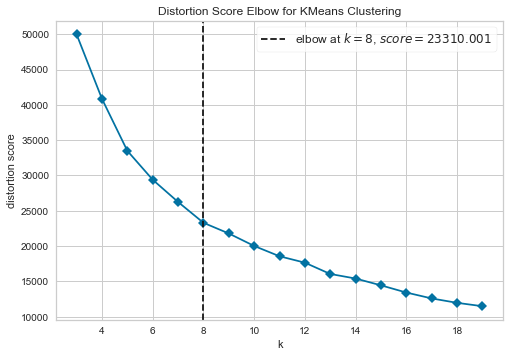

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
#NON RUNNARE QUESTO CODICE!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,20), timings=False)
visualizer.fit(pca_df)
visualizer.show()

From this plot we can say that the optimal number of cluster is k = 8, why after that the cost function decrese slower.

**InterCluster Distance method**

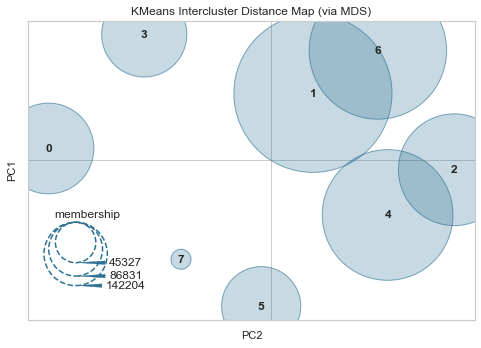

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [292]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans()
visualizer = InterclusterDistance(model)

visualizer.fit(pca_df)   
visualizer.show()

Also using the InterCluster Distance method it can be seen that the optimal number of clusters is k = 8.

**Terzo metodo per vedere veramente quanti cluster prendere**

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False, locate_elbow=False
)

visualizer.fit(pca_df)        # Fit the data to the visualizer
visualizer.show() 

**Let's apply the k means implemented by us to our dataset, using the number of clusters indicated by the two methods above**

In [296]:
#tipo una roba cosi
cluster = my_kmeans(pca_df, 8, 20) #ci mette tipo 30 secondi
pca_df_cluster = pca_df.copy()
pca_df_cluster['cluster'] = cluster
#ora devi aggiungere i cluster come colonna a pca_df

In [295]:
pca_df

,0,1,2,3
0,0.356,0.374,0.089,-0.101
1,0.021,-0.122,-0.100,-0.010
2,0.249,-0.150,-0.206,-0.210
3,-0.081,-0.163,0.158,-0.029
4,0.102,0.261,-0.085,0.290
...,...,...,...,...
839076,-0.072,-0.025,-0.102,0.051
839077,-0.209,0.130,0.166,-0.033
839078,-0.201,0.141,-0.094,-0.029
839079,-0.081,-0.156,-0.102,-0.039


**K-means++**

In [ ]:
#qui ci va quello con init = k-means++ (vedi sotto dovrebbe esserci)

In [ ]:
#kmeans = KMeans(n_clusters=8, init='k-means++', random_state = 42).fit_predict(pca_df) #lo mettiamo random state?

In [ ]:
#cicciobello["cluster"]=kmeans

with respect to our Kmeans this elbow suggests the same number of clusters, as we can see from the slowdown of the cost of the solution after six clusters, but it is less segmented and this is due to the fact that Kmeans ++ reduces randomness of the Kmeans's solution so the descent of the cost of the solution is cleaner.

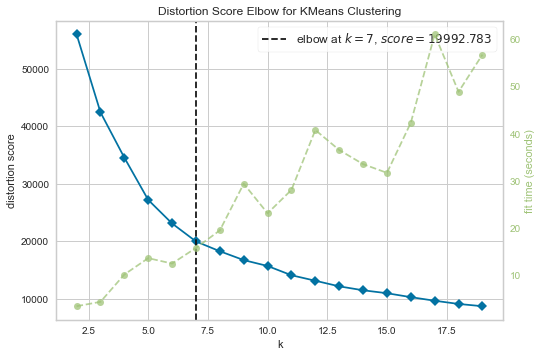

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [293]:
model = KMeans(init='k-means++')
visualizer = KElbowVisualizer(model, k = (2,20), metric = "distortion")
visualizer.fit(pca_df)
visualizer.show()
#iniziato a runnare alle 12.00
#finito alle 12.15

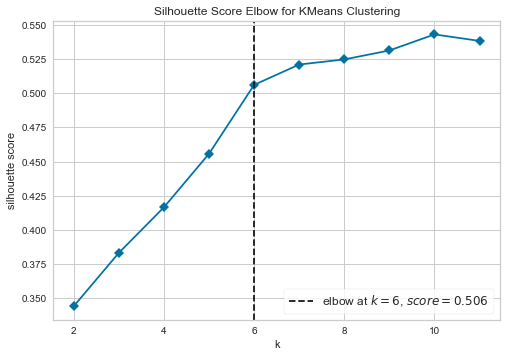

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [277]:
model = KMeans()
vis = KElbowVisualizer(model, k = (2,12), metric = 'silhouette', timings = False)
vis.fit(pca_df2)
vis.show()
#inizio a runnare alle 10.43
#finito di runnare alle 11.52

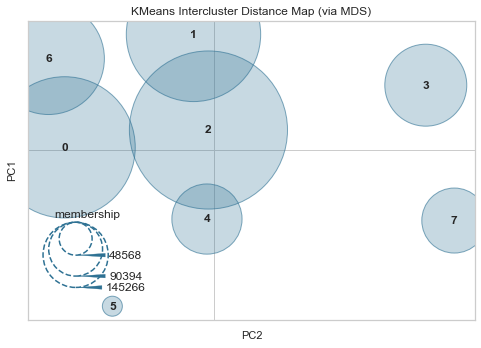

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [281]:
from yellowbrick.cluster import InterclusterDistance

model = KMeans()
visualizer = InterclusterDistance(model)

visualizer.fit(pca_df)   
visualizer.show()

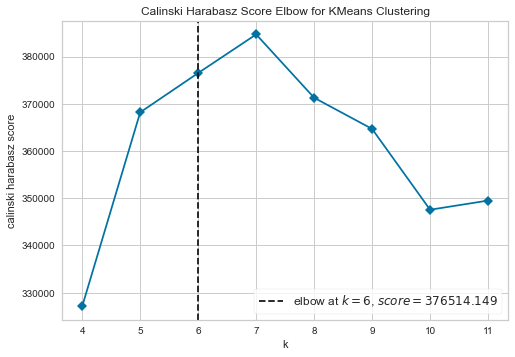

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [304]:
model = KMeans()
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='calinski_harabasz', timings=False, locate_elbow=False
)

visualizer.fit(pca_df)        # Fit the data to the visualizer
visualizer.show() 